In [1]:
# Has multi-dimensional arrays and matrices.
# Has a large collection of mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# Data visualization tools.
import seaborn as sns

import mesa

Matplotlib is building the font cache; this may take a moment.
Fontconfig warning: ignoring UTF-8: not a valid region tag


## Setup

In [80]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def say_wealth(self):
        print(f"Hi, I am agent {self.unique_id!s} and I have {self.wealth} monies")

    def exchange(self):
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.agents)
            if other_agent is not None:
                other_agent.wealth += 1
                self.wealth -= 1

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents(
            [self.pos]
        )  # Input can be more than one cell, empty cells are excluded from result
        # This agent is included in results-- remove it to prevent giving money to self
        cellmates.pop((cellmates.index(self)))
        if len(cellmates) > 0:
            other = self.model.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def move(self):
        # Types of cell neighborhoods: Moore is all 8 adjacent cells; Von Neumann is only cardinal direction (up/down/left/right)
        neighborhood = self.model.grid.get_neighborhood(
            pos=self.pos,  # Agent pos is updated by grid move/place actions!
            moore=True,
            include_center=False,
        )
        new_pos = self.random.choice(neighborhood)
        self.model.grid.move_agent(self, new_pos)


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width=10, height=10, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n

        self.grid = mesa.space.MultiGrid(
            width=width, height=height, torus=True
        )  # Torus is the donut shape! Allows top-> bottom moves, etc
        # collect the output
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, 
            agent_reporters={"Wealth": "wealth"}
        )

        # Create n agents
        MoneyAgent.create_agents(model=self, n=n)

        # Assign a random starting position to each agent
        x = self.rng.integers(
            low=0, high=width, size=(n,)
        )  # Size is optionally a tuple, ((m, n, k) --> m * n * k values)
        y = self.rng.integers(low=0, high=height, size=(n,))
        for a, i, j in zip(self.agents, x, y):
            self.grid.place_agent(a, (i, j))

    def step(self):
        """Advance the model by one step."""
        # A step is the smallest unit of time in the model, also called a 'tick'
        # shuffle_do() psuedo-randomly reorders the list of agents and
        # then calls the function passed as a paramter
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

    def basic_step(self):
        """ This step was the first one created in the tutorial, we moved on """
        self.agents.shuffle_do("exchange")

    def show_status(self):
        """Show the state of each agent"""
        self.agents.do("say_wealth")

## Running the model

### Basic example

In [81]:
 # Create agents
model = MoneyModel(10)
model.show_status()
for _ in range(30):
    model.basic_step()

# The money has shuffled
model.show_status()

Hi, I am agent 1 and I have 1 monies
Hi, I am agent 2 and I have 1 monies
Hi, I am agent 3 and I have 1 monies
Hi, I am agent 4 and I have 1 monies
Hi, I am agent 5 and I have 1 monies
Hi, I am agent 6 and I have 1 monies
Hi, I am agent 7 and I have 1 monies
Hi, I am agent 8 and I have 1 monies
Hi, I am agent 9 and I have 1 monies
Hi, I am agent 10 and I have 1 monies
Hi, I am agent 1 and I have 2 monies
Hi, I am agent 2 and I have 1 monies
Hi, I am agent 3 and I have 2 monies
Hi, I am agent 4 and I have 0 monies
Hi, I am agent 5 and I have 0 monies
Hi, I am agent 6 and I have 2 monies
Hi, I am agent 7 and I have 0 monies
Hi, I am agent 8 and I have 1 monies
Hi, I am agent 9 and I have 2 monies
Hi, I am agent 10 and I have 0 monies


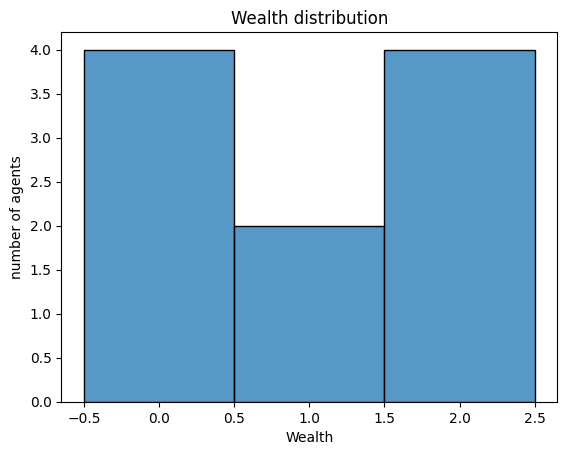

In [82]:
agent_wealth = [a.wealth for a in model.agents]
# Create a histogram with seaborn
g = sns.histplot(agent_wealth, discrete=True)
g.set(
    title="Wealth distribution", xlabel="Wealth", ylabel="number of agents"
);  # The semicolon is just to avoid printing the object representation

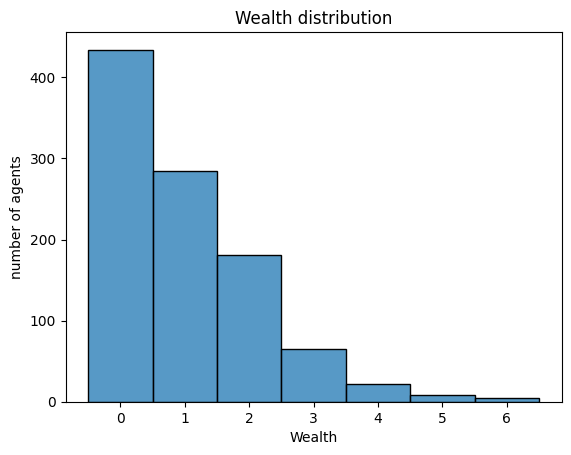

In [83]:
all_wealth = []
# This runs the model 100 times, each model executing 30 steps.
for _ in range(100):
    # Run the model
    model = MoneyModel(10)
    for _ in range(30):
        model.basic_step()

    # Store the results
    for agent in model.agents:
        all_wealth.append(agent.wealth)

# Use seaborn
g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

### Adding space

In [84]:
model = MoneyModel(10, 10, 10)
print(model.agents)

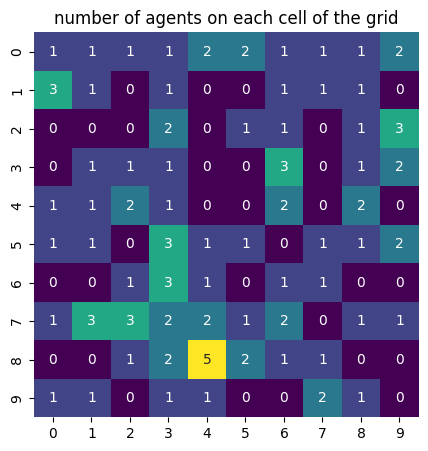

In [85]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()

# Visualize it with a numpy grid
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    cell_count = len(cell_content)
    agent_counts[x][y] = cell_count
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="number of agents on each cell of the grid");


### Collect data about wealth inequality

[Text(0.5, 1.0, 'Gini Coefficient over Time'),
 Text(0, 0.5, 'Gini Coefficient')]

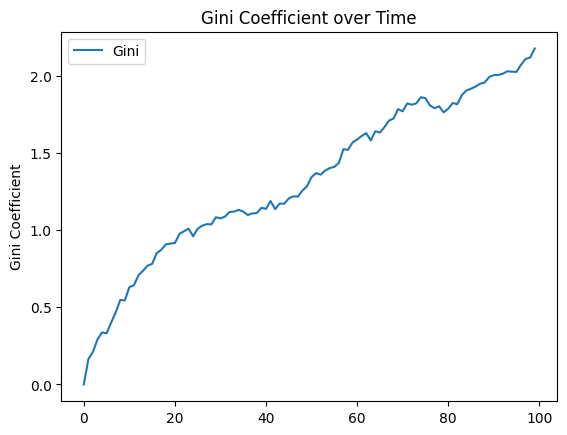

In [89]:
model = MoneyModel(100, 10, 10)
for _ in range(100):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient")

[Text(0.5, 1.0, 'Distribution of wealth at the end of simulation'),
 Text(0.5, 0, 'Wealth'),
 Text(0, 0.5, 'number of agents')]

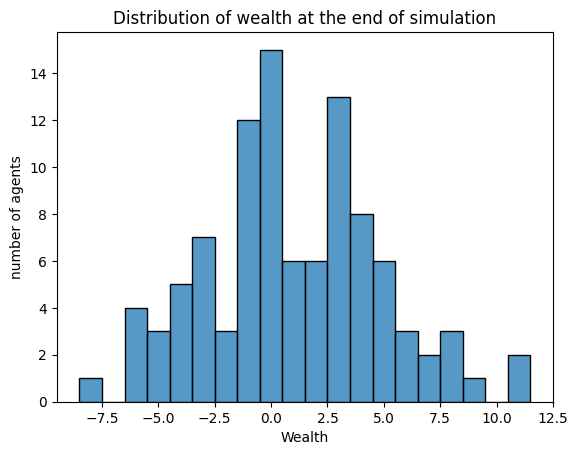

In [92]:
# Get agent-wealth data
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()
last_step = agent_wealth.index.get_level_values("Step").max()
end_wealth = agent_wealth.xs(last_step, level="Step")["Wealth"]
# Create a histogram of wealth at the last step
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at the end of simulation",
    xlabel="Wealth",
    ylabel="number of agents",
)

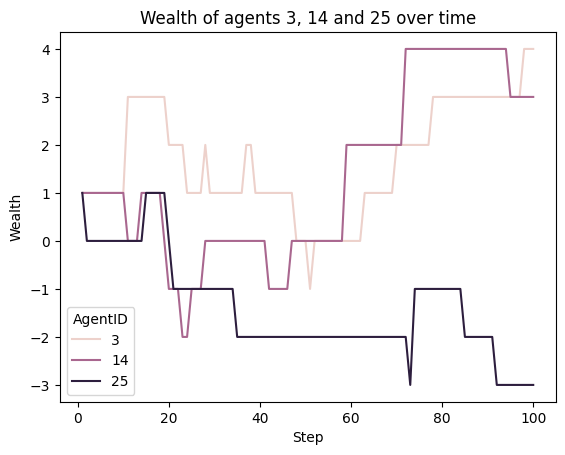

In [94]:
agent_list = [3, 14, 25]

# Get the wealth of multiple agents over time
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
# Plot the wealth of multiple agents over time
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");